# Imports

In [1]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from time import time
from torch.utils.data import DataLoader
from Code.gram import GRAM_RTM
from Code.act_maps import ActivationMaps
from Code.rcnn_models.linear_1 import BackboneTail as Linear1
from Code.rcnn_models.linear_1_conv_1 import BackboneTail as Linear1Conv1
from Code.rcnn_models.linear_1_conv_2 import BackboneTail as Linear1Conv2
from Code.rcnn_models.linear_2_conv_1 import BackboneTail as Linear2Conv1
from Code.rcnn_models.linear_2_conv_2 import BackboneTail as Linear2Conv2
from Code.rcnn_models.linear_3_conv_3 import BackboneTail as Linear3Conv3
from Code.specialized_nn import PytorchResNet as SpecializedNN
from Code.faster_rcnn import FasterRCNN

# Datasets

In [2]:
gram_dataset_train = GRAM_RTM(prefix="GRAM", split="train", spec_nn=True)
gram_dataset_val = GRAM_RTM(prefix="GRAM", split="val", spec_nn=True)
gram_dataset_test = GRAM_RTM(prefix="GRAM", split="test", spec_nn=True)
act_map_dataset_train = ActivationMaps(prefix="GRAM", split="train")
act_map_dataset_val = ActivationMaps(prefix="GRAM", split="val")
act_map_dataset_test = ActivationMaps(prefix="GRAM", split="test")
gram_dataloader_train = DataLoader(gram_dataset_train, batch_size=16, shuffle=True)
gram_dataloader_val = DataLoader(gram_dataset_val, batch_size=16, shuffle=True)
gram_dataloader_test = DataLoader(gram_dataset_test, batch_size=16, shuffle=True)
act_map_dataloader_train = DataLoader(act_map_dataset_train, batch_size=16, shuffle=True)
act_map_dataloader_val = DataLoader(act_map_dataset_val, batch_size=16, shuffle=True)
act_map_dataloader_test = DataLoader(act_map_dataset_test, batch_size=16, shuffle=True)

# Methods

In [3]:
import torch.nn.functional as F
criterion = F.cross_entropy

def train(loader, model, optimizer):
    '''
    Train the model for one epoch.
    '''
    total_loss, total_time = 0, 0
    for batch_idx, batch in enumerate(loader):
        inputs, targets = batch[0].cuda(), batch[1].cuda()
        optimizer.zero_grad()
        start_time = time()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        total_time += time() - start_time
        total_loss += loss.item()
        optimizer.step()
    return total_loss / 4512, total_time
                
def evaluate_val(loader, model):
    '''
    Compute loss on val or test data.
    '''
    total_loss, correct, total_time = 0, 0, 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            inputs, targets = batch[0].cuda(), batch[1].cuda()
            start_time = time()
            output = model(inputs)
            total_time += time() - start_time
            total_loss += criterion(output, targets).item()
            pred = torch.argmax(output, dim=1)
            correct += (pred == targets).sum().item()
    return total_loss / 1504, 100. * correct / 1504, total_time

def evaluate_test(loader, model):
    '''
    Compute loss on val or test data.
    '''
    total_loss, correct = 0, 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            inputs, targets = batch[0].cuda(), batch[1].cuda()
            output = model(inputs)
            total_loss += criterion(output, targets).item()
            pred = torch.argmax(output, dim=1)
            correct += (pred == targets).sum().item()
    return total_loss / 1504, 100. * correct / 1504

# Accuracy & Speed (Long Training)

In [4]:
!rm GRAM/maps && ln -s ~/HDD/mask_maps_50_small GRAM/maps
NUM_RUNS, NUM_EPOCHS = 10, 15

### Specialized NN

In [5]:
spnn_train_loss, spnn_val_loss, spnn_val_acc, spnn_test_loss, spnn_test_acc, spnn_train_time, spnn_inf_time \
    = np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), \
      np.zeros((NUM_RUNS)), np.zeros((NUM_RUNS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS))
for run in range(NUM_RUNS):
    model = SpecializedNN().cuda()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(NUM_EPOCHS):
        print(f'\r{run + 1} - {epoch + 1}\t', end='')
        train_loss, train_time = train(gram_dataloader_train, model, optimizer)
        spnn_train_loss[run, epoch] = train_loss
        spnn_train_time[run, epoch] = train_time
        val_loss, val_acc, inf_time = evaluate_val(gram_dataloader_val, model)
        spnn_val_loss[run, epoch] = val_loss
        spnn_val_acc[run, epoch] = val_acc
        spnn_inf_time[run, epoch] = inf_time
    test_loss, test_acc = evaluate_test(gram_dataloader_test, model)
    spnn_test_loss[run] = test_loss
    spnn_test_acc[run] = test_acc

10 - 15	

### 1 Linear + 1 Conv

In [ ]:
l1c1_train_loss, l1c1_val_loss, l1c1_val_acc, l1c1_test_loss, l1c1_test_acc, l1c1_train_time, l1c1_inf_time \
    = np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), \
      np.zeros((NUM_RUNS)), np.zeros((NUM_RUNS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS))
for run in range(NUM_RUNS):
    model = Linear1Conv1().cuda()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(NUM_EPOCHS):
        print(f'\r{run + 1} - {epoch + 1}\t', end='')
        train_loss, train_time = train(act_map_dataloader_train, model, optimizer)
        l1c1_train_loss[run, epoch] = train_loss
        l1c1_train_time[run, epoch] = train_time
        val_loss, val_acc, inf_time = evaluate_val(act_map_dataloader_val, model)
        l1c1_val_loss[run, epoch] = val_loss
        l1c1_val_acc[run, epoch] = val_acc
        l1c1_inf_time[run, epoch] = inf_time
    test_loss, test_acc = evaluate_test(act_map_dataloader_test, model)
    l1c1_test_loss[run] = test_loss
    l1c1_test_acc[run] = test_acc

### 2 Linear + 1 Conv

In [7]:
l2c1_train_loss, l2c1_val_loss, l2c1_val_acc, l2c1_test_loss, l2c1_test_acc, l2c1_train_time, l2c1_inf_time \
    = np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), \
      np.zeros((NUM_RUNS)), np.zeros((NUM_RUNS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS))
for run in range(NUM_RUNS):
    model = Linear2Conv1().cuda()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(NUM_EPOCHS):
        print(f'\r{run + 1} - {epoch + 1}\t', end='')
        train_loss, train_time = train(act_map_dataloader_train, model, optimizer)
        l2c1_train_loss[run, epoch] = train_loss
        l2c1_train_time[run, epoch] = train_time
        val_loss, val_acc, inf_time = evaluate_val(act_map_dataloader_val, model)
        l2c1_val_loss[run, epoch] = val_loss
        l2c1_val_acc[run, epoch] = val_acc
        l2c1_inf_time[run, epoch] = inf_time
    test_loss, test_acc = evaluate_test(act_map_dataloader_test, model)
    l2c1_test_loss[run] = test_loss
    l2c1_test_acc[run] = test_acc

10 - 15	

### 1 Linear + 2 Conv

In [8]:
l1c2_train_loss, l1c2_val_loss, l1c2_val_acc, l1c2_test_loss, l1c2_test_acc, l1c2_train_time, l1c2_inf_time \
    = np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), \
      np.zeros((NUM_RUNS)), np.zeros((NUM_RUNS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS))
for run in range(NUM_RUNS):
    model = Linear1Conv2().cuda()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(NUM_EPOCHS):
        print(f'\r{run + 1} - {epoch + 1}\t', end='')
        train_loss, train_time = train(act_map_dataloader_train, model, optimizer)
        l1c2_train_loss[run, epoch] = train_loss
        l1c2_train_time[run, epoch] = train_time
        val_loss, val_acc, inf_time = evaluate_val(act_map_dataloader_val, model)
        l1c2_val_loss[run, epoch] = val_loss
        l1c2_val_acc[run, epoch] = val_acc
        l1c2_inf_time[run, epoch] = inf_time
    test_loss, test_acc = evaluate_test(act_map_dataloader_test, model)
    l1c2_test_loss[run] = test_loss
    l1c2_test_acc[run] = test_acc

10 - 15	

### 2 Linear + 2 Conv

In [9]:
l2c2_train_loss, l2c2_val_loss, l2c2_val_acc, l2c2_test_loss, l2c2_test_acc, l2c2_train_time, l2c2_inf_time \
    = np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), \
      np.zeros((NUM_RUNS)), np.zeros((NUM_RUNS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS))
for run in range(NUM_RUNS):
    model = Linear2Conv2().cuda()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(NUM_EPOCHS):
        print(f'\r{run + 1} - {epoch + 1}\t', end='')
        train_loss, train_time = train(act_map_dataloader_train, model, optimizer)
        l2c2_train_loss[run, epoch] = train_loss
        l2c2_train_time[run, epoch] = train_time
        val_loss, val_acc, inf_time = evaluate_val(act_map_dataloader_val, model)
        l2c2_val_loss[run, epoch] = val_loss
        l2c2_val_acc[run, epoch] = val_acc
        l2c2_inf_time[run, epoch] = inf_time
    test_loss, test_acc = evaluate_test(act_map_dataloader_test, model)
    l2c2_test_loss[run] = test_loss
    l2c2_test_acc[run] = test_acc

10 - 15	

### 3 Linear + 3 Conv

In [10]:
l3c3_train_loss, l3c3_val_loss, l3c3_val_acc, l3c3_test_loss, l3c3_test_acc, l3c3_train_time, l3c3_inf_time \
    = np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), \
      np.zeros((NUM_RUNS)), np.zeros((NUM_RUNS)), np.zeros((NUM_RUNS, NUM_EPOCHS)), np.zeros((NUM_RUNS, NUM_EPOCHS))
for run in range(NUM_RUNS):
    model = Linear3Conv3().cuda()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(NUM_EPOCHS):
        print(f'\r{run + 1} - {epoch + 1}\t', end='')
        train_loss, train_time = train(act_map_dataloader_train, model, optimizer)
        l3c3_train_loss[run, epoch] = train_loss
        l3c3_train_time[run, epoch] = train_time
        val_loss, val_acc, inf_time = evaluate_val(act_map_dataloader_val, model)
        l3c3_val_loss[run, epoch] = val_loss
        l3c3_val_acc[run, epoch] = val_acc
        l3c3_inf_time[run, epoch] = inf_time
    test_loss, test_acc = evaluate_test(act_map_dataloader_test, model)
    l3c3_test_loss[run] = test_loss
    l3c3_test_acc[run] = test_acc

10 - 15	

## Plots

### Training Loss

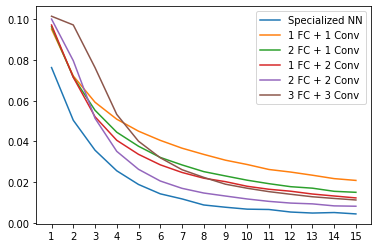

In [11]:
x = list(range(1, NUM_EPOCHS + 1))
plt.plot(x, np.mean(spnn_train_loss, axis=0), label='Specialized NN')
plt.plot(x, np.mean(l1c1_train_loss, axis=0), label='1 FC + 1 Conv')
plt.plot(x, np.mean(l2c1_train_loss, axis=0), label='2 FC + 1 Conv')
plt.plot(x, np.mean(l1c2_train_loss, axis=0), label='1 FC + 2 Conv')
plt.plot(x, np.mean(l2c2_train_loss, axis=0), label='2 FC + 2 Conv')
plt.plot(x, np.mean(l3c3_train_loss, axis=0), label='3 FC + 3 Conv')
plt.legend(loc='best')
plt.xticks(x);

### Validation Loss

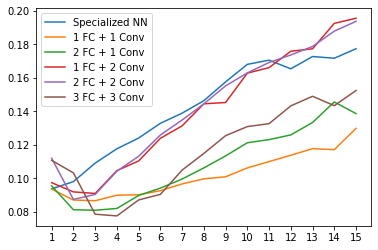

In [12]:
x = list(range(1, NUM_EPOCHS + 1))
plt.plot(x, np.mean(spnn_val_loss, axis=0), label='Specialized NN')
plt.plot(x, np.mean(l1c1_val_loss, axis=0), label='1 FC + 1 Conv')
plt.plot(x, np.mean(l2c1_val_loss, axis=0), label='2 FC + 1 Conv')
plt.plot(x, np.mean(l1c2_val_loss, axis=0), label='1 FC + 2 Conv')
plt.plot(x, np.mean(l2c2_val_loss, axis=0), label='2 FC + 2 Conv')
plt.plot(x, np.mean(l3c3_val_loss, axis=0), label='3 FC + 3 Conv')
plt.legend(loc='best')
plt.xticks(x);

### Validation Accuracy

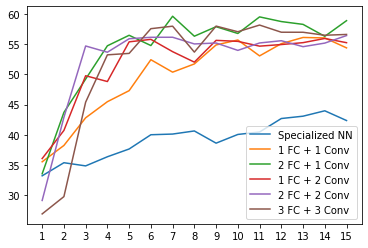

In [13]:
x = list(range(1, NUM_EPOCHS + 1))
plt.plot(x, np.mean(spnn_val_acc, axis=0), label='Specialized NN')
plt.plot(x, np.mean(l1c1_val_acc, axis=0), label='1 FC + 1 Conv')
plt.plot(x, np.mean(l2c1_val_acc, axis=0), label='2 FC + 1 Conv')
plt.plot(x, np.mean(l1c2_val_acc, axis=0), label='1 FC + 2 Conv')
plt.plot(x, np.mean(l2c2_val_acc, axis=0), label='2 FC + 2 Conv')
plt.plot(x, np.mean(l3c3_val_acc, axis=0), label='3 FC + 3 Conv')
plt.legend(loc='best')
plt.xticks(x);

### Test Loss

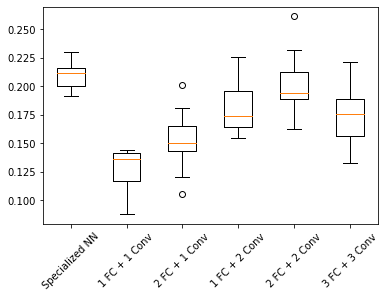

In [14]:
losses = (spnn_test_loss, l1c1_test_loss, l2c1_test_loss, l1c2_test_loss, l2c2_test_loss, l3c3_test_loss)
labels = ('Specialized NN', '1 FC + 1 Conv', '2 FC + 1 Conv', '1 FC + 2 Conv', '2 FC + 2 Conv', '3 FC + 3 Conv')
plt.boxplot(losses, labels=labels)
plt.xticks(rotation=45);

### Test Accuracy

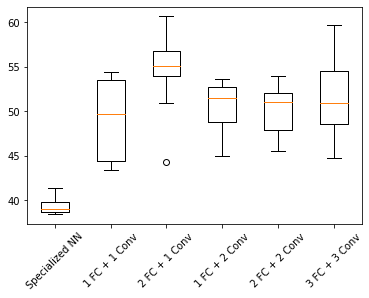

In [15]:
accs = (spnn_test_acc, l1c1_test_acc, l2c1_test_acc, l1c2_test_acc, l2c2_test_acc, l3c3_test_acc)
plt.boxplot(accs, labels=labels)
plt.xticks(rotation=45);

### Training Speed

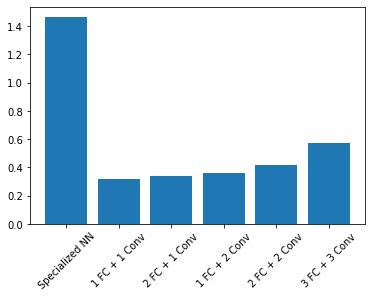

In [16]:
train_times = (spnn_train_time.mean(), l1c1_train_time.mean(), l2c1_train_time.mean(), l1c2_train_time.mean(), l2c2_train_time.mean(), l3c3_train_time.mean())
plt.bar(labels, train_times)
plt.xticks(rotation=45);

### Inference Speed

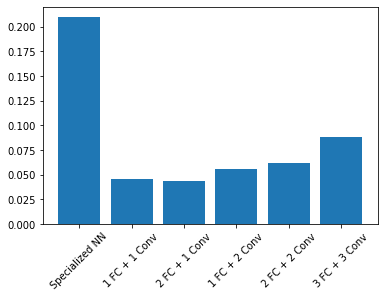

In [17]:
inf_times = (spnn_inf_time.mean(), l1c1_inf_time.mean(), l2c1_inf_time.mean(), l1c2_inf_time.mean(), l2c2_inf_time.mean(), l3c3_inf_time.mean())
plt.bar(labels, inf_times)
plt.xticks(rotation=45);

# Correlations

In [18]:
!rm GRAM/maps && ln -s ~/HDD/mask_maps_50_small GRAM/maps
NUM_EPOCHS = 15

In [19]:
gram_dataset_detectron_val = GRAM_RTM(prefix="GRAM", detectron=True, split="val")
gram_dataset_detectron_test = GRAM_RTM(prefix="GRAM", detectron=True, split="test")

gram_dataset_spnn_train = GRAM_RTM(prefix="GRAM", spec_nn=True, split="train")
gram_dataset_spnn_val = GRAM_RTM(prefix="GRAM", spec_nn=True, split="val")
gram_dataset_spnn_test = GRAM_RTM(prefix="GRAM", spec_nn=True, split="test")
gram_dataloader_spnn = DataLoader(gram_dataset_spnn_train, batch_size=16, shuffle=True)

act_map_dataset_rcnn_train = ActivationMaps(prefix="GRAM", split="train")
act_map_dataset_rcnn_val = ActivationMaps(prefix="GRAM", split="val")
act_map_dataset_rcnn_test = ActivationMaps(prefix="GRAM", split="test")
act_map_dataloader_rcnn = DataLoader(act_map_dataset_rcnn_train, batch_size=16, shuffle=True)

### Mask R-CNN

In [20]:
model = FasterRCNN()
rcnn_counts = []
with torch.no_grad():
    for i in range(len(gram_dataset_detectron_val)):
        print(f'\r{i}\t', end='')
        image = gram_dataset_detectron_val[i][0]
        rcnn_counts.append(model.forward(image))
    for i in range(len(gram_dataset_detectron_test)):
        print(f'\r{i}\t', end='')
        image = gram_dataset_detectron_test[i][0]
        rcnn_counts.append(model.forward(image))

0	

/home/rodrigo/.local/lib/python3.8/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


1503	

### Specialized NN

In [21]:
model = SpecializedNN().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
for epoch in range(NUM_EPOCHS):
    print(f'\r{epoch + 1}\t', end='')
    train(gram_dataloader_spnn, model, optimizer)
print(evaluate_test(gram_dataloader_spnn, model))

15	(0.021492710570337876, 287.5)


In [22]:
spnn_counts = []
with torch.no_grad():
    for i in range(len(gram_dataset_spnn_val)):
        print(f'\r{i}\t', end='')
        image = gram_dataset_spnn_val[i][0]
        image = image.cuda().unsqueeze(0)
        num_cars = torch.argmax(model(image), dim=1).cpu().item()
        spnn_counts.append(num_cars)
    for i in range(len(gram_dataset_spnn_test)):
        print(f'\r{i}\t', end='')
        image = gram_dataset_spnn_test[i][0]
        image = image.cuda().unsqueeze(0)
        num_cars = torch.argmax(model(image), dim=1).cpu().item()
        spnn_counts.append(num_cars)

1503	

### 2 Linear + 1 Conv

In [23]:
model = Linear2Conv1().cuda()
optimizer = optim.Adam(model.parameters())
for epoch in range(NUM_EPOCHS):
    print(f'\r{epoch + 1}\t', end='')
    train(act_map_dataloader_rcnn, model, optimizer)
print(evaluate_test(act_map_dataloader_rcnn, model))

15	(0.03394829917902206, 280.718085106383)


In [25]:
l2c1_counts = []
with torch.no_grad():
    for i in range(len(act_map_dataset_rcnn_val)):
        print(f'\r{i}\t', end='')
        image = act_map_dataset_rcnn_val[i][0]
        image = image.cuda().unsqueeze(0)
        num_cars = torch.argmax(model(image), dim=1).cpu().item()
        l2c1_counts.append(num_cars)
    for i in range(len(act_map_dataset_rcnn_test)):
        print(f'\r{i}\t', end='')
        image = act_map_dataset_rcnn_test[i][0]
        image = image.cuda().unsqueeze(0)
        num_cars = torch.argmax(model(image), dim=1).cpu().item()
        l2c1_counts.append(num_cars)

1503	

## Correlations

In [26]:
cov = np.cov(rcnn_counts, spnn_counts)
print(f'Correlation with Specialized NN: {cov[0,1] / (np.sqrt(cov[0,0]) * np.sqrt(cov[1,1]))}')
cov = np.cov(rcnn_counts, l2c1_counts)
print(f'Correlation with our model: {cov[0,1] / (np.sqrt(cov[0,0]) * np.sqrt(cov[1,1]))}')

Correlation with Specialized NN: 0.5534537046358261
Correlation with our model: 0.6982202848647621
